In [19]:
import warnings
warnings.filterwarnings("ignore")

In [20]:
%pip install torch

Note: you may need to restart the kernel to use updated packages.


In [21]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

Graph Convolutional Auto-Encoder

In [22]:
# Laplace normalization
class LplsNorm(nn.Module):
    def __init__(self):
        super(LplsNorm, self).__init__()

    def forward(self, adjacency_matrix):
        degree = torch.sum(adjacency_matrix, dim=-1)
        diag = torch.diag(torch.pow(degree, -0.5))
        out = diag.mm(adjacency_matrix).mm(diag)
        return out

# convolutional
class Convolution(nn.Module):
    def __init__(self, in_dimension, out_dimension):
        super(Convolution, self).__init__()
        self.LinearLayer = nn.Sequential(
            nn.Linear(in_dimension, out_dimension),
            nn.ReLU()
        )

    def forward(self, adjacency_matrix, feature):
        mf = feature + torch.mm(adjacency_matrix, feature)
        out = self.LinearLayer(mf)
        return out

class ConvolutionLayer(nn.Module):
    def __init__(self, in_dimension, embedding_dimension):
        super(ConvolutionLayer, self).__init__()
        self.LplsNorm = LplsNorm()

        self.Convolution = Convolution(in_dimension, embedding_dimension)

    def forward(self, adjacency_matrix, feature):
        adjacency_matrix = self.LplsNorm(adjacency_matrix)
        out = self.Convolution(adjacency_matrix, feature)
        return out

class GraphConvolution(nn.Module):
    # in_dimenssion: input_dimenssion
    def __init__(self, in_dimension, embedding_dimension):
        super(GraphConvolution, self).__init__()
        self.ConvolutionLayer = ConvolutionLayer(in_dimension, embedding_dimension)
        
        self.LinearLayer = nn.Sequential(
            nn.Linear(embedding_dimension, in_dimension),
            nn.ReLU(),
            nn.Linear(in_dimension, in_dimension)
        )

    def forward(self, matrix, feature):
        re = self.ConvolutionLayer(matrix, feature)
        rd = self.LinearLayer(re)
        
        return rd, re

preset parameter

In [23]:
dataset = "dataset2"
lnc_mi = pd.read_csv('./our_dataset/' + dataset + '/interaction/lnc_mi.csv', index_col='0').values
mi_di = pd.read_csv('./our_dataset/' + dataset + '/interaction/mi_di.csv', index_col='0').values
lnc_di = pd.read_csv('./our_dataset/' + dataset + '/interaction/lnc_di.csv', index_col='0').values
L_num = lnc_mi.shape[0]
D_num = mi_di.shape[1]
M_num = mi_di.shape[0]
print(f"{L_num} --- {D_num} --- {M_num}")

665 --- 316 --- 295


In [24]:
A = np.load('./our_dataset/' + dataset + '/A/A_1_1.npy')
folds = 10
in_dimension = A.shape[1]
embedding_dimension = 128
learn_rate = 1e-3
weight_decay = 1e-5
n_epochs = 100
network_num = 4

train

In [25]:
print("Start training")
rds = []
res = []
for fold in range(folds):
    d = []
    e = []
    for i in range(network_num):
        epoch = 0
        A = torch.Tensor(np.load('./our_dataset/' + dataset + '/A/A_' + str(fold + 1) + '_' + str(i + 1) + '.npy'))
        model = GraphConvolution(in_dimension, embedding_dimension)
        optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate, weight_decay=weight_decay)
        loss_function = nn.MSELoss(reduction='mean')
        while epoch < n_epochs:
            model.train()
            optimizer.zero_grad()
            rd, re = model(A, A)
            loss = loss_function(rd, A)
            loss.backward()
            optimizer.step()
            epoch += 1
        model.eval()
        with torch.no_grad():
            rd, re = model(A, A)
            d.append(rd)
            e.append(re)
        print(f"The layer {fold + 1} graph convolutional auto-encoder loss is {loss.detach().cpu().item()}")
    res.append(e)
    rds.append(d)

Start training


The layer 1 graph convolutional auto-encoder loss is 0.009836183860898018
The layer 1 graph convolutional auto-encoder loss is 0.01041699294000864
The layer 1 graph convolutional auto-encoder loss is 0.010375265963375568
The layer 1 graph convolutional auto-encoder loss is 0.0103451581671834
The layer 2 graph convolutional auto-encoder loss is 0.009752633981406689
The layer 2 graph convolutional auto-encoder loss is 0.010174980387091637
The layer 2 graph convolutional auto-encoder loss is 0.010179949924349785
The layer 2 graph convolutional auto-encoder loss is 0.010104529559612274
The layer 3 graph convolutional auto-encoder loss is 0.009674097411334515
The layer 3 graph convolutional auto-encoder loss is 0.010354745201766491
The layer 3 graph convolutional auto-encoder loss is 0.010298546403646469
The layer 3 graph convolutional auto-encoder loss is 0.010162311606109142
The layer 4 graph convolutional auto-encoder loss is 0.009444491006433964
The layer 4 graph convolutional auto-enco

Save the results

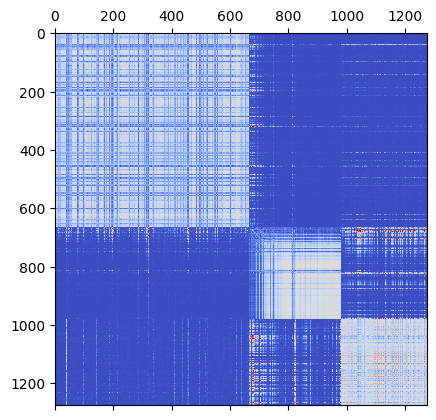

In [26]:
for fold in range(folds):
    for i in range(network_num):
        np.save('./our_dataset/' + dataset + '/A_encoder/A_' + str(fold + 1) + '_' + str(i + 1), res[fold][i].detach().numpy())
plt.matshow(rds[0][0].detach().numpy(), cmap=plt.cm.coolwarm, vmin=0, vmax=1)